* CNN on MNIST by PyTorch

In [1]:
import sys
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from sklearn import model_selection, metrics
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.autograd import Variable
from tqdm import tqdm

In [2]:
gpu = 0
device = torch.device("cuda:{}".format(gpu) if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
import urllib
from sklearn.datasets import fetch_mldata

try:
    mnist = fetch_mldata('MNIST original')
except urllib.error.HTTPError as ex:
    from six.moves import urllib
    from scipy.io import loadmat
    import os
    print('Could not download MNIST data from mldata.org, trying alternative...')
    mnist_alternative_url = 'https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat'
    mnist_path = './mnist-original.mat'
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, 'wb') as f:
        content = response.read()
        f.write(content)
    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw['data'].T,
        "target": mnist_raw['label'][0],
        "COL_NAMES": ['label', 'data'],
        "DESCR": 'mldata.org dataset: mnist-original',
    }
    print('Success!')

In [4]:
mnist['data'] = mnist['data'].astype(np.float32).reshape(len(mnist['data']), 1, 28, 28) # image data
mnist['data'] /= 255
mnist['target'] = mnist['target'].astype(np.int32) # label data
mnist['data'].shape, mnist['target'].shape

((70000, 1, 28, 28), (70000,))

In [5]:
# train data size : validation data size= 8 : 2
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(mnist['data'], mnist['target'], test_size=0.2)

# DataLoader化
batch_size = 1000
train = torch.utils.data.TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid = torch.utils.data.TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size)
len(train_loader), len(valid_loader)

(56, 14)

In [6]:
# モデルクラス定義

class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        # 画像を畳み込みを行うまで
        self.head = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=20, kernel_size=(5, 5), stride=1, padding=0),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5), stride=1, padding=0),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # 畳み込みで得られたベクトルを出力層に順伝播させるまで
        self.tail = nn.Sequential(
            nn.Linear(50*4*4, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, 10)
        )
    
    def __call__(self, x):
        
        h = self.head(x)
        h = h.view(-1, 50*4*4)
        y = self.tail(h)
        return y

In [7]:
# test

model = CNN()
xs, ys = iter(train_loader).next()
print(xs.size())
preds = model(Variable(xs))
preds.shape

torch.Size([1000, 1, 28, 28])


torch.Size([1000, 10])

In [8]:
model = CNN()

if torch.cuda.is_available():
    model.to(device)
    
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [9]:
def forward(data_loader, train=True):
    
    running_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (xs, ys) in enumerate(data_loader):
        
        if torch.cuda.is_available():
            xs, ys = xs.to(device), ys.to(device).long()
            
        preds = model(xs)
        
        if train:
            optimizer.zero_grad()
            
            loss = criterion(preds, ys)
            running_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
        else:
            loss = criterion(preds, ys)
            running_loss += loss.item()
            
        _, pred_labels = torch.max(preds.data, 1)
        correct += (pred_labels == ys.data).sum().item()
        total += ys.size(0)

    loss = running_loss / len(data_loader)
    acc = correct / total
    
    return loss, acc    

In [10]:
# 学習

epoch_num = 5

for epoch in tqdm(range(epoch_num), file=sys.stdout):
    
    train_loss, train_acc = forward(train_loader)
    val_loss, val_acc = forward(valid_loader, train=False)
    
    if (epoch+1) % 1 == 0:
        tqdm.write('epoch:\t{}\ttrain loss:\t{:.5f}\ttrain acc:\t{:.5f}\tval loss:\t{:.5f}\tval acc:\t{:.5f}'.format(
            epoch+1, train_loss, train_acc, val_loss, val_acc)
        )

epoch:	1	train loss:	0.62843	train acc:	0.82121	val loss:	0.18639	val acc:	0.94286
epoch:	2	train loss:	0.13478	train acc:	0.95946	val loss:	0.08982	val acc:	0.97221
epoch:	3	train loss:	0.07862	train acc:	0.97600	val loss:	0.06848	val acc:	0.97850
epoch:	4	train loss:	0.05616	train acc:	0.98261	val loss:	0.06634	val acc:	0.97800
epoch:	5	train loss:	0.04141	train acc:	0.98739	val loss:	0.04751	val acc:	0.98507
100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


In [11]:
model.cpu()

CNN(
  (head): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (tail): Sequential(
    (0): Linear(in_features=800, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=10, bias=True)
  )
)

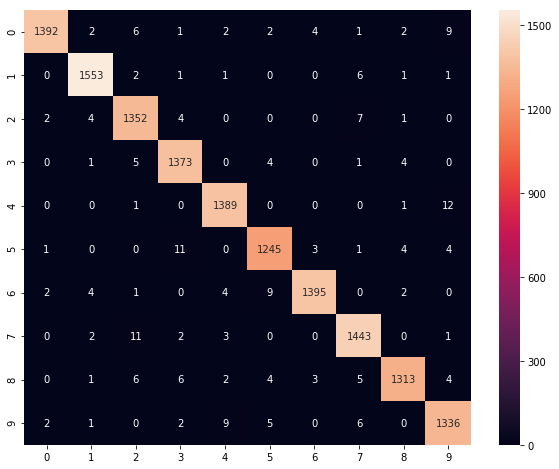

In [13]:
loader = torch.utils.data.DataLoader(valid, batch_size=len(valid_x))

for i, (x, y) in enumerate(loader):
    
    preds = model(x)
    _, pred_labels = torch.max(preds.data, 1)

cm = metrics.confusion_matrix(pred_labels, valid_y)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

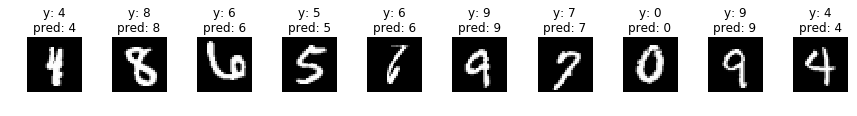

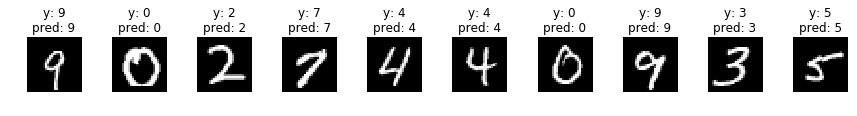

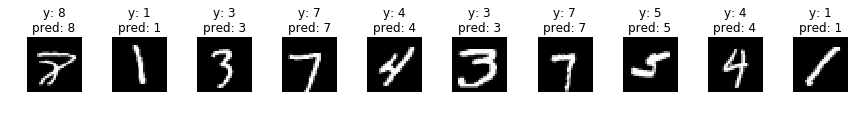

In [14]:
indices = np.random.choice(len(valid_x), 30)

for i, idx in enumerate(indices):
    
    if i%10 == 0:
        fig, axs = plt.subplots(ncols=10, figsize=(15,1))
    
    x = valid_x[idx]
    y = valid_y[idx]
    
    x_img = x.reshape(28, 28)
    x = x[np.newaxis]
    x = torch.from_numpy(x)
    
    pred = model(x)
    pred = pred.data.numpy()
    p = np.argmax(pred, axis=1)[0]

    axs[i%10].imshow(x_img, cmap='gray')
    title = 'y: {}'.format(y) + '\n' + 'pred: {}'.format(p)
    axs[i%10].set_title(title)
    axs[i%10].axis('off')

plt.show()

In [15]:
!python --version

Python 3.6.3


In [16]:
!pip freeze

absl-py==0.2.0
astor==0.6.2
backcall==0.1.0
bleach==1.5.0
boto==2.49.0
boto3==1.7.73
botocore==1.10.73
bz2file==0.98
certifi==2018.4.16
chainer==4.0.0
chainercv==0.10.0
chardet==3.0.4
cntk-gpu==2.5.1
cupy==4.0.0
cycler==0.10.0
Cython==0.28.2
decorator==4.3.0
dm-sonnet==1.20
docutils==0.14
edward==1.3.5
entrypoints==0.2.3
fastrlock==0.3
filelock==3.0.4
future==0.16.0
gast==0.2.0
gensim==3.5.0
graphviz==0.8.3
grpcio==1.11.0
h5py==2.7.1
html5lib==0.9999999
idna==2.6
ipykernel==4.8.2
ipython==6.3.1
ipython-genutils==0.2.0
ipywidgets==7.2.1
jedi==0.12.0
Jinja2==2.10
jmespath==0.9.3
jsonschema==2.6.0
jupyter==1.0.0
jupyter-client==5.2.3
jupyter-console==5.2.0
jupyter-core==4.4.0
Keras==2.1.6
kiwisolver==1.0.1
Lasagne==0.2.dev1
leveldb==0.194
Mako==1.0.7
Markdown==2.6.11
MarkupSafe==1.0
matplotlib==2.2.2
mecab-python3==0.7
mistune==0.8.3
mxnet-cu90==1.1.0.post0
nbconvert==5.3.1
nbformat==4.4.0
networkx==2.1
nose==1.3.7
notebook==5.4.1
numpy==1.14.3
pandas==0.22.0
pandocfilters==1.4.2
parso==0

In [17]:
!cat /proc/driver/nvidia/version

NVRM version: NVIDIA UNIX x86_64 Kernel Module  384.111  Tue Dec 19 23:51:45 PST 2017
GCC version:  gcc version 5.4.0 20160609 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 


In [18]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Sep__1_21:08:03_CDT_2017
Cuda compilation tools, release 9.0, V9.0.176
